In [1]:
%matplotlib inline

In [2]:
import pystan
import arviz as az

In [3]:
import pickle
from hashlib import md5

def stan_cache(model_code, model_name=None, **kwargs):
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    cache_fn = './cache/cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [4]:
np.random.seed(1)

In [5]:
mu, sigma = 3., 1.

In [6]:
sample = np.random.lognormal(mu, sigma, 1000) + 1

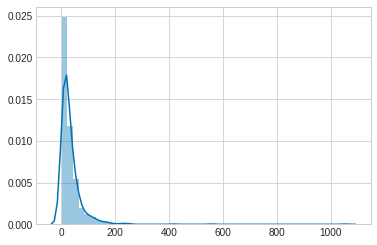

In [7]:
sns.distplot(sample)

In [8]:
pd.Series(sample).to_frame().describe().T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,34.926502,50.866295,1.947655,12.021408,21.932291,41.609927,1053.162347


## pareto

In [9]:
pareto = """
data {
    int<lower=0> N;
    real<lower=1.0> x[N];
    real<lower=0> minx;
}
parameters {
    real<lower=0.0001,upper=minx>   alpha;
    real<lower=0.0001>  beta; 
}
model {
    for(n in 1:N){
        x[n] ~ pareto(alpha, beta);
    }
}
generated quantities{
    vector[N] log_lik;

    for(n in 1:N){
        log_lik[n] = pareto_lpdf(x[n]|alpha,beta);
    }
}
"""

In [10]:
data = {
    'N': len(sample),
    'x':  sample,
    'minx': 0.1
}

sm1 = stan_cache(model_code=pareto)
params1 = sm1.sampling(data=data, iter=6000, warmup=2000)

Using cached StanModel


In [11]:
pd.DataFrame({'mu': params1['alpha'], 'sigma': params1['beta']}).describe().T

,count,mean,std,min,25%,50%,75%,max
mu,16000.0,0.099460,0.000538,0.095107,0.099256,0.099624,0.099842,0.10000
sigma,16000.0,0.184782,0.005934,0.163882,0.180769,0.184670,0.188680,0.20863


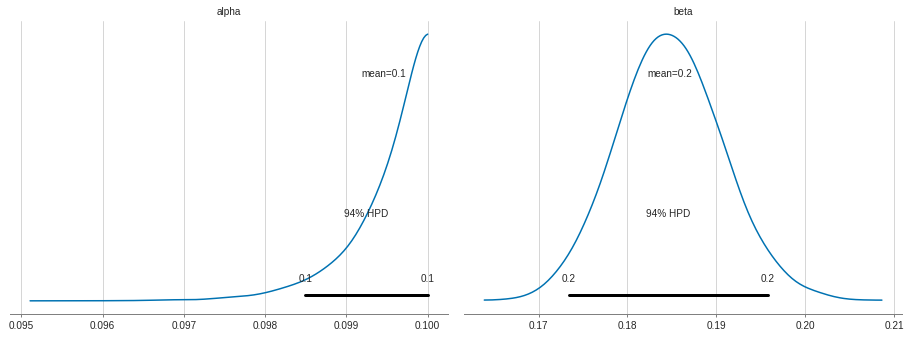

In [12]:
az.plot_posterior(params1, var_names=['alpha', 'beta']);

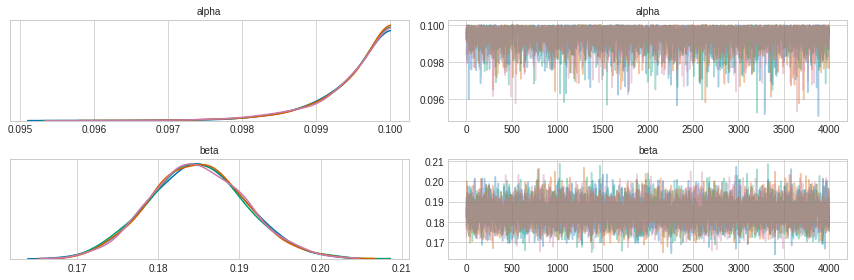

In [13]:
az.plot_trace(params1, var_names=('alpha', 'beta'));

## log_normal

In [14]:
log_normal = """
data {
  int<lower=0> N;
  real<lower=0.999> x[N];
}
parameters {
  real  mu;  
  real<lower=0>   sigma;
}
model {
  for(n in 1:N){
    x[n] ~ lognormal(mu,sigma);
  }
}
generated quantities{
  vector[N] log_lik;
  
  for(i in 1:N){
    log_lik[i] = lognormal_lpdf(x[i]|mu,sigma);
  }
}
"""

In [15]:
data = {
    'N': len(sample),
    'x':  sample
}

sm2 = stan_cache(model_code=log_normal)
params2 = sm2.sampling(data=data, iter=6000, warmup=2000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc7abf8948cc9690adf089d1d95cf946 NOW.


In [16]:
pd.DataFrame({'mu': params2['mu'], 'sigma': params2['sigma']}).describe().T

,count,mean,std,min,25%,50%,75%,max
mu,16000.0,3.110886,0.028945,2.984323,3.091254,3.110931,3.130439,3.240718
sigma,16000.0,0.915464,0.020341,0.833944,0.901398,0.915012,0.929091,0.998131


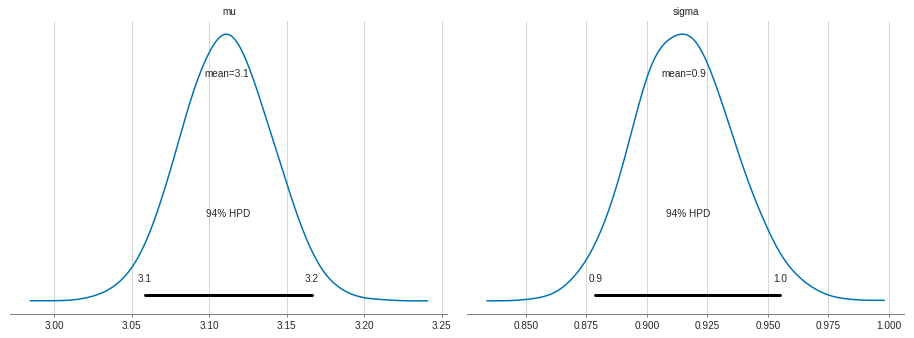

In [17]:
az.plot_posterior(params2, var_names=['mu', 'sigma']);

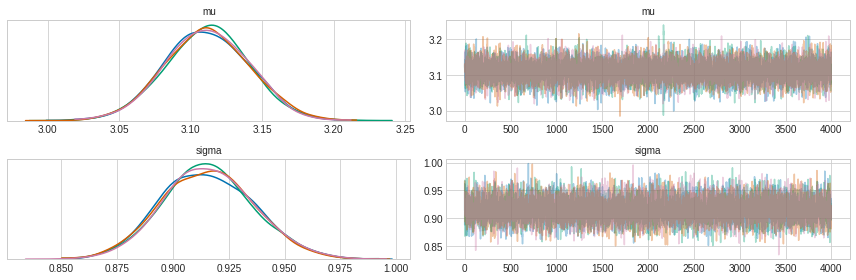

In [18]:
az.plot_trace(params2, var_names=('mu', 'sigma'));

## gamma

In [19]:
gamma = """
data {
  int<lower=0> N;
  real<lower=0.999> x[N];
}
parameters {
  real<lower=0.0001>  alpha;
  real<lower=0.0001>   beta;
}
model {
  for(i in 1:N){
    x[i] ~ gamma(alpha,beta);
  }
}
generated quantities{
  vector[N] log_lik;

  for(i in 1:N){
    log_lik[i] = gamma_lpdf(x[i]|alpha,beta);
  }
}
"""

In [20]:
data = {
    'N': len(sample),
    'x':  sample
}

sm3 = stan_cache(model_code=gamma)
params3 = sm3.sampling(data=data, iter=6000, warmup=2000)

Using cached StanModel


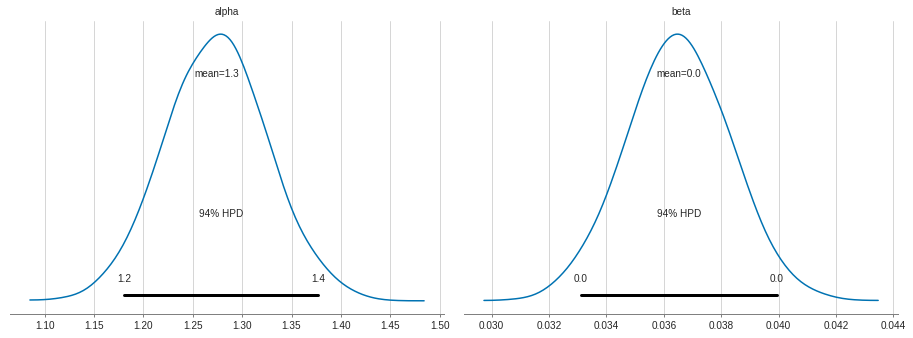

In [21]:
az.plot_posterior(params3, var_names=['alpha', 'beta']);

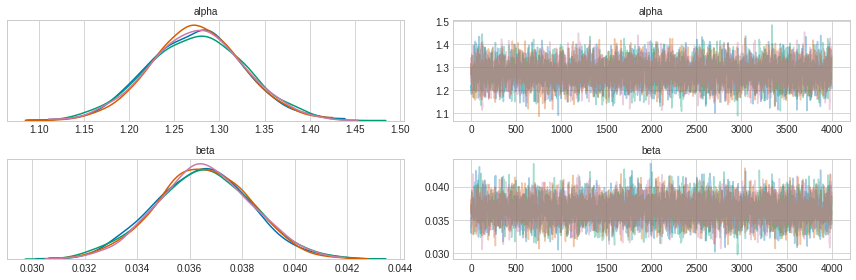

In [22]:
az.plot_trace(params3, var_names=('alpha', 'beta'));

## WBIC

In [23]:
def wbic(log_likelihood):
    return - np.mean(np.sum(log_likelihood, axis=1))

In [24]:
pd.Series({
    "pareto": wbic(params1['log_lik']),
    "log_normal": wbic(params2['log_lik']),
    "gamma": wbic(params3['log_lik'])}
).to_frame().rename(columns={0: "WBIC"}).T

,pareto,log_normal,gamma
WBIC,5801.200122,4440.704985,4537.58292


## WAIC

In [25]:
def waic(log_likelihood):
    training_error = - np.mean(np.log(np.mean(np.exp(log_likelihood), axis=0)))
    functional_variance_div_N = np.mean((np.mean(log_likelihood**2, axis=0)) - np.mean(log_likelihood)**2)
    return training_error + functional_variance_div_N

In [26]:
pd.Series({
    "pareto": waic(params1['log_lik']),
    "log_normal": waic(params2['log_lik']),
    "gamma": waic(params3['log_lik'])}
).to_frame().rename(columns={0: "WAIC"}).T

,pareto,log_normal,gamma
WAIC,6.973615,5.916316,7.401111
